In [1]:
#%load_ext line_profiler
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
from ozone import Ozone
from load_ac import stack_antenna_ac
from standing_waves import remove_standing_waves
import h5py


In [2]:
mir_data = MirParser("/mnt/Storage1/Ozone/OzoneData/211009_04:56:19", has_auto=True)
freq_range = [min(mir_data.sp_data['fsky']) - 2.0, max(mir_data.sp_data['fsky']) + 2.0]
ozone_model = Ozone('/mnt/Storage1/Ozone/newdata/', freq_range=freq_range)
pwv = 2
_ = ozone_model(zenith=0.1, pwv=pwv, return_pwv_jacobian=True)

In [3]:
compass_solns = h5py.File('/mnt/Storage1/Ozone/10923_specsoln.mat')
bpArr = np.square(compass_solns['bandpassArr']).sum(axis=-1)
freq_arr = np.divide(compass_solns['freqArr'], 1e9)
scaleFac = np.swapaxes(np.asarray(compass_solns['gainApEff']).reshape(8, 2, -1), axis1=0, axis2=1)
sbArr = compass_solns['sbArr'][0]
winArr = compass_solns['winArr'][0]

print("Idx | SB  | Chunk")
print("-----------------")
for idx in range(12):
    print(f" {idx:>2d} | {"USB" if sbArr[idx] == 1.0 else "LSB"} |   {int(winArr[idx])}")

Idx | SB  | Chunk
-----------------
  0 | LSB |   6
  1 | LSB |   5
  2 | LSB |   4
  3 | LSB |   3
  4 | LSB |   2
  5 | LSB |   1
  6 | USB |   1
  7 | USB |   2
  8 | USB |   3
  9 | USB |   4
 10 | USB |   5
 11 | USB |   6


In [4]:
freqs, stacked, meta = stack_antenna_ac(
    mir_data,
    antenna_num=6,
    rx_num=0,
    normalization=False,
    return_meta=True,
    spw_baselining=False,
    mad_dev=15.0,
    window_size=11,
)

In [5]:
elevation = meta['actual_el']
tsys = meta['tsys']

1 1.3066565524580083 1.0296795725602441 73.15083709127029 63.5153987963077
2 0.8136001949332344 0.8790133293929145 48.73240901967638 43.99068438558293
4 1.1005048131648372 1.1482982349335105 78.67520133540405 95.67982624995444
5 1.1944246869540551 1.1874216354131533 58.350290922040955 45.001889211617964
6 0.8622408838528661 0.7461120312808558 58.8906506434639 60.8086642341921
7 1.311217263521191 1.1915826780791374 80.28538887250791 47.714996533605614
8 1.1042681460819905 0.7998481544016811 82.00942658156076 54.0633034361918


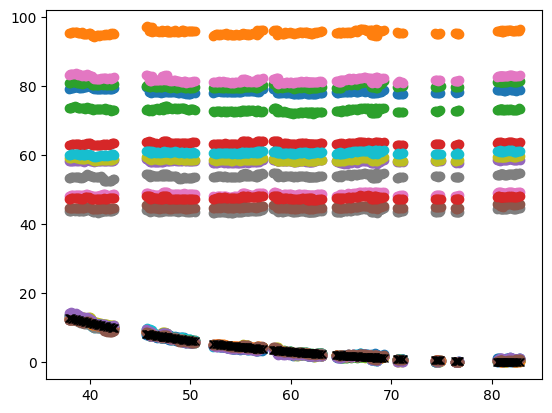

In [6]:
pwv=2.0
mir_data.select(reset=True)
elevation = mir_data.eng_data.get_value("actual_el", where=("antenna", "eq", 1))
model_data = np.array([np.mean(ozone_model(zenith=np.radians(90 - el), pwv=pwv)[0]) for el in elevation])
for antenna in np.unique(mir_data.eng_data['antenna']):
    mir_data.select(('antenna', 'eq', antenna), reset=True)
    elevation, tsysA, tsysB = mir_data.eng_data[['actual_el', 'tsys', 'tsys_rx2']]
    aScale = np.mean(model_data-model_data.min()) / np.mean(tsysA-tsysA.min())
    bScale = np.mean((model_data-model_data.min())) / np.mean((tsysB-tsysB.min()))
    plt.plot(elevation, (tsysA-tsysA.min())*aScale, 'o')
    plt.plot(elevation, (tsysB-tsysB.min())*bScale, 'o')
    plt.plot(elevation, (tsysA * aScale) - model_data, 'o')
    plt.plot(elevation, (tsysB * bScale) - model_data, 'o')
    print(antenna, aScale, bScale, np.mean((tsysA * aScale) - model_data), np.mean((tsysB * bScale) - model_data))

plt.plot(elevation, model_data - model_data.min(),'kx')

In [7]:
model_arr = np.zeros_like(stacked)
za_arr = np.radians(90 - elevation)
model_freqs = ozone_model.data['freq']['map']
nspws = stacked.shape[1]
for idx, zenith in enumerate(za_arr):
    model_temps = ozone_model(pwv=pwv, zenith=zenith)[0][0, 0]
    for jdx, spw_freqs in enumerate(freqs):
        model_subarr = model_arr[idx, jdx]
        for sb_freqs, gain_fac in zip(spw_freqs, [1.1, 0.9]):
            model_subarr += np.interp(sb_freqs, model_freqs, model_temps) * gain_fac

In [8]:
old_stack = stacked * 1
tsys = 73 * 2
new_stack = stacked / (model_arr+tsys)

for item in [old_stack, new_stack]:
    item /= np.nanmedian(item,axis=0)[None]
    item /= np.nanmedian(item,axis=2)[:, :, None]

/tmp/ipykernel_8226/2200192237.py:6: RuntimeWarning: All-NaN slice encountered
  item /= np.nanmedian(item,axis=0)[None]


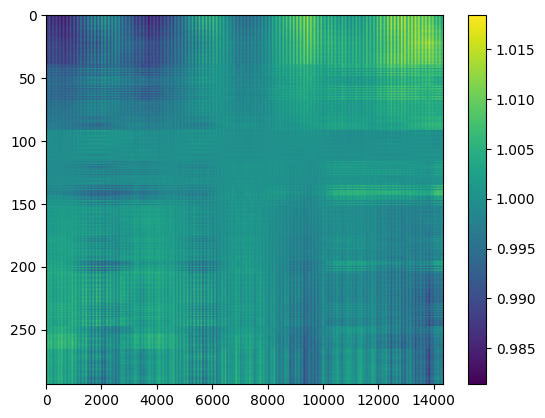

In [9]:
plt.imshow(new_stack[np.argsort(elevation), 3, :], aspect='auto')
plt.colorbar()

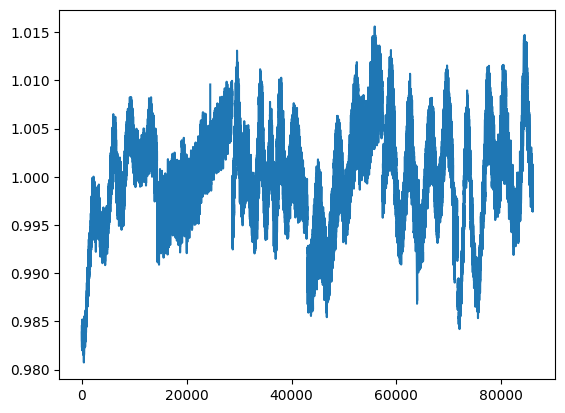

In [10]:
plt.plot(new_stack[50, :].flatten())

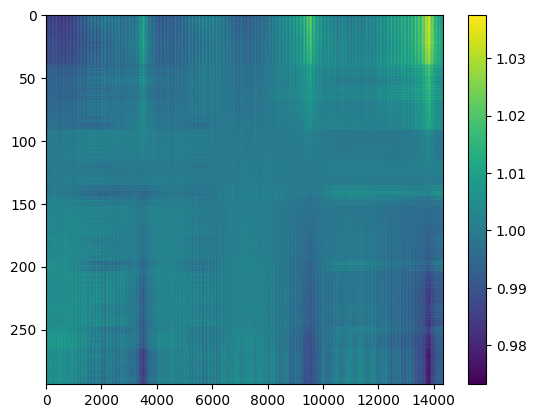

In [11]:
plt.imshow(old_stack[np.argsort(elevation), 3, :], aspect='auto')
plt.colorbar()

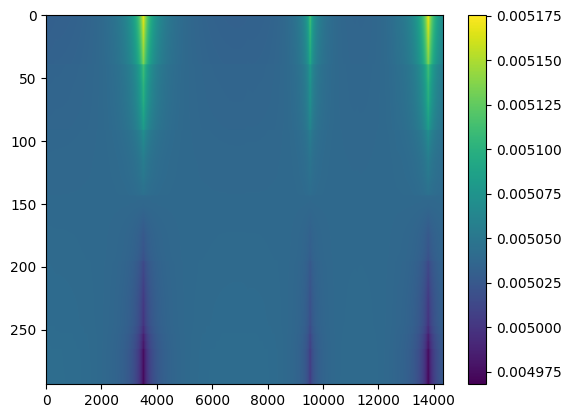

In [12]:
plt.imshow(
    (
        ((model_arr[np.argsort(elevation), 3, :] + tsys)
            / np.median(model_arr[np.argsort(elevation), 3, :] + tsys, axis=1)[:, None])
            / np.median(model_arr[np.argsort(elevation), 3, :] + tsys, axis=0)
    ),
    aspect='auto')
plt.colorbar()

(1, 10000.0)

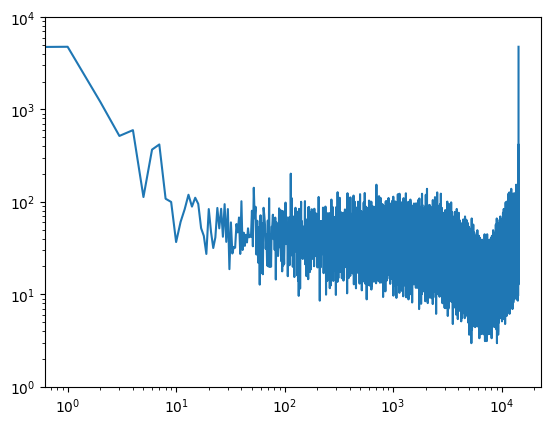

In [13]:
test_slice = 1 * new_stack[52, :, :]
test_slice[np.isnan(test_slice)] = 0

for i in range(6):
    test_slice[i, :] -= np.nanmean(test_slice[i, :])

plt.loglog(np.sum(np.abs(np.fft.fft(test_slice, axis=1))**2.0, axis = 0))
plt.ylim(1, 1e4)

In [14]:
freqs[:, 1].shape

(6, 14336)

In [15]:
model, cleaned = remove_standing_waves(new_stack, freqs[:, 1], [(1 / 46.7), (1 / 17.8), (1 / 63.5)], 
                                       n_harmonics = 2, freq_order = 1, baseline_order = 2)

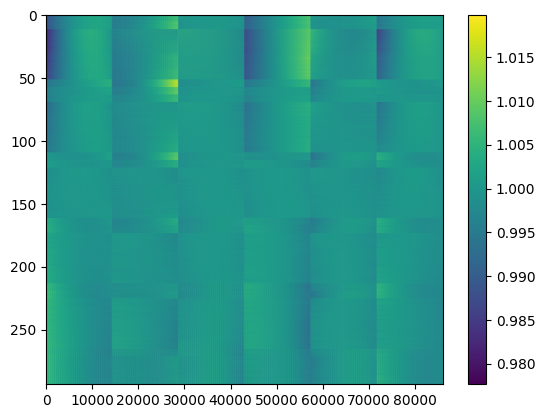

In [17]:
plt.imshow(model.reshape(294, 14336*6), aspect='auto')
plt.colorbar()

In [18]:
model.shape

(294, 6, 14336)

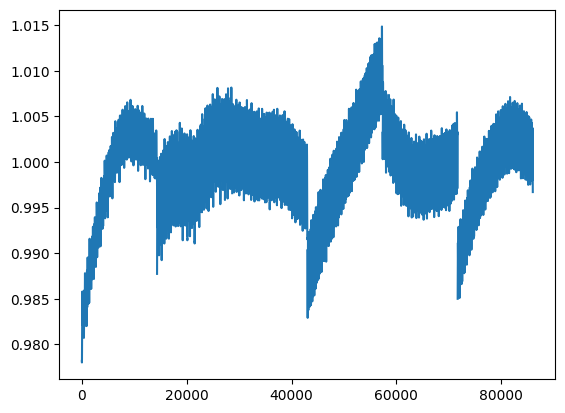

In [19]:
plt.plot(model[25, :].flatten())
#plt.xlim(0, 1000)

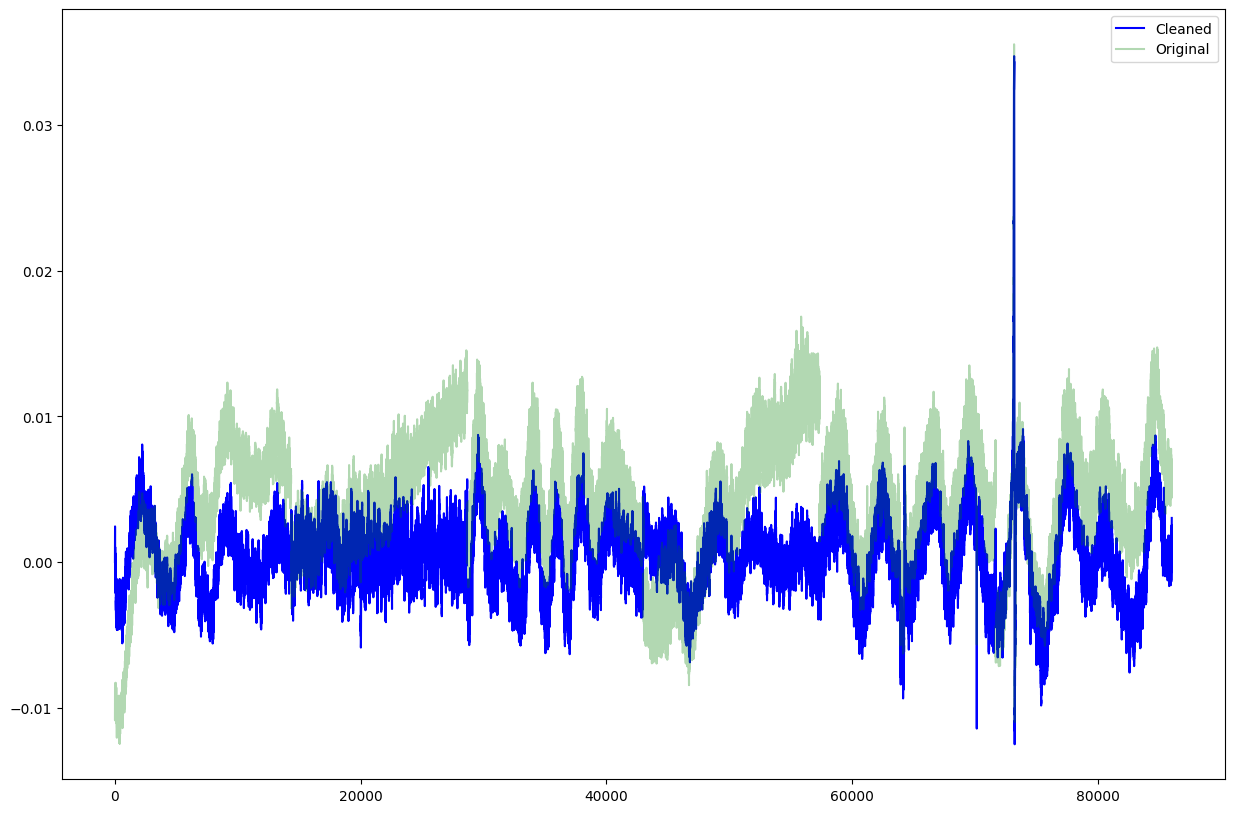

In [33]:
idx = 0
plt.figure(figsize=(15, 10))
plt.plot(cleaned[idx, :].flatten(), color='b', label = "Cleaned")
plt.plot(new_stack[idx, :].flatten()-0.9825-0.013, color='g', label = "Original", alpha=0.3)
plt.plot()
#plt.plot(model[25, :].flatten() - 1, color='g')
#plt.plot(model[25, :].flatten()-1, color='r', alpha=1, label = "Model")
#plt.ylim(-0.015, -0.013)
plt.legend()
#plt.xlim(15000, 17000)
#plt.xlim(5000, 7000)
#plt.xlim(40000, 47000)
#plt.xlim(70000, 77000)

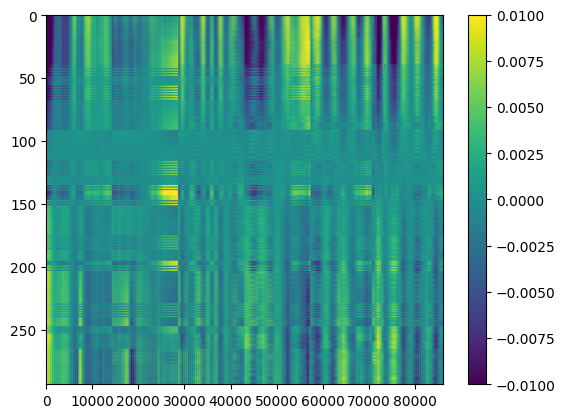

In [42]:
plt.imshow(new_stack.reshape(294, 14336*6)[np.argsort(elevation)]-np.nanmean(new_stack), aspect='auto', vmin = -0.01, vmax=0.01)
plt.colorbar()

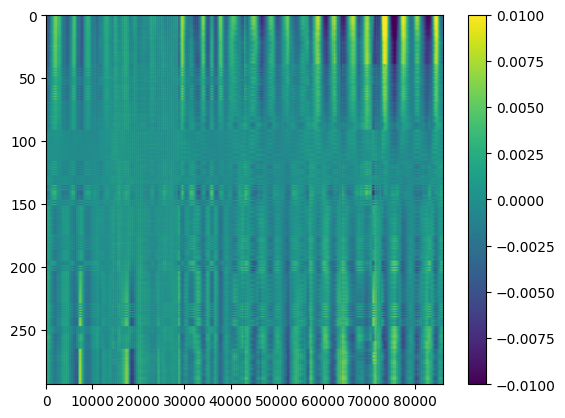

In [43]:
plt.imshow(cleaned.reshape(294, 14336*6)[np.argsort(elevation)] - np.nanmean(cleaned), aspect='auto', vmin=-0.01, vmax = 0.01)
plt.colorbar()